In [1]:
import pandas as pd
import dask.dataframe as dd

import imp
prepare_data = imp.load_source('prepare_data', '../src/prepare_data.py')
process_data = imp.load_source('processe_data', '../src/process_data.py')

In [2]:
import seaborn as sns

**Top perfomances**

In [3]:
dfs = []
for name in ['standard', 'noise', 'probend', 'probend_noise']:
    df = pd.read_csv('../data/%s_v3_processed.csv' % name, index_col=0
                           )
    df['type'] = name
    dfs.append(df)

/home/nightwing/anaconda3/envs/axlml/lib/python3.5/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
[df.size for df in dfs]

[37355868, 38462025, 37363110, 38462025]

In [5]:
[len(df.seed.unique()) for df in dfs]

[12285, 12287, 12287, 12287]

In [7]:
average_prfs = []
types = []
for df in dfs:
    types.append(df['type'].unique()[0])
    average_prfs.append(df.groupby(['Name']).median()['Normalized_Rank'])

In [10]:
for prf, tps in zip(average_prfs, types):
    table = pd.DataFrame(prf.sort_values()[:15])
    table = table.rename(columns={'Normalized_Rank':
                                  r'$\bar{R}$ in %s tournaments' % tps})
    table.to_latex('../paper/performance_%s_table.tex' % tps)
    

In [20]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import gaussian_kde

%matplotlib inline

In [21]:
def get_distribution_without_outliers(distribution, percentage=0.1):
    distribution.sort()
    size_of_ditribution = len(distribution)
    outliers = int(size_of_ditribution * (percentage))
    
    return distribution[:-outliers]

**Top variation**

In [22]:
def plot_perfomance_violin_plots(type_index,
                                 tournament_type,
                                 top_names,
                                 ylim_up=1,
                                 remove_outliers=False,
                                 percentage=0.1):
    data, violin_data = [], []
    top_names.reverse()
    for name in top_names:
        distribution = dfs[type_index][dfs[type_index]['Name'] == name]['Normalized_Rank'].values
        
        data.append(distribution)
        
        if remove_outliers:
            distribution = get_distribution_without_outliers(distribution, percentage)
        violin_data.append(distribution)

    means = [np.mean(dt) for dt in data]

    fig, axes = plt.subplots(figsize=(10, 4))

    parts = axes.violinplot(violin_data, showextrema=False,
                            showmeans=False);

    boxes = axes.boxplot(data, showfliers=False)
    axes.scatter(range(1, len(means) + 1), means, marker='o', color='purple', zorder=3, s=50)

    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)

    for bp in boxes['medians']:
        bp.set_color('purple')
        bp.set_linewidth(2)
        bp.set_linestyle('-.')
    for bp in boxes['caps']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['whiskers']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['boxes']:
        bp.set_color('navy')
        bp.set_linewidth(2)

    axes.set_title('Top performances in %s tournaments' % tournament_type)
    axes.set_ylim([0, ylim_up]);
    axes.set_xticklabels(list(top_names), rotation=90);

    fig.savefig('../images/performance_%s.pdf' % tournament_type,
                bbox_inches='tight')

In [23]:
top_names = list(average_prfs[0].sort_values()[:15].index)

In [24]:
dfs[0]['size'].mean(), dfs[0]['turns'].mean(), dfs[0]['repetitions'].mean()

(122.27344812333098, 100.93296726500907, 55.06043676993398)

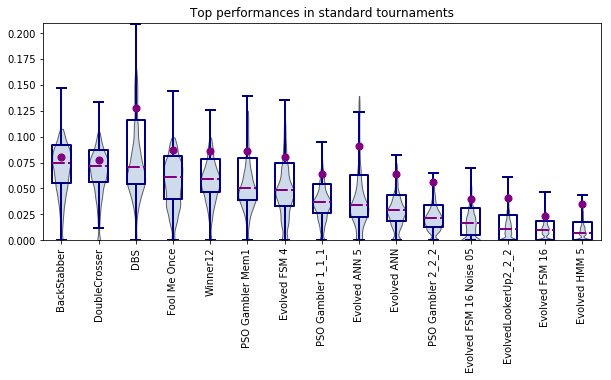

In [25]:
plot_perfomance_violin_plots(type_index=0,
                             tournament_type=types[0],
                             top_names=top_names,
                             ylim_up=0.21,
                             remove_outliers=True,
                             percentage=0.15)

In [49]:
sserror, coop = [], []
top_names.reverse()

In [50]:
for name in top_names:
    sserror_dist = dfs[0][dfs[0]['Name'] == name]['SSeeror'].values
    sserror.append(sserror_dist)
    
    coop_dist = dfs[0][dfs[0]['Name'] == name]['Cooperation_rating'].values
    coop.append(coop_dist)

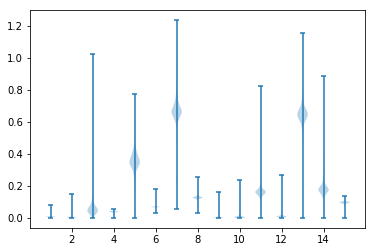

In [51]:
plt.violinplot(sserror);

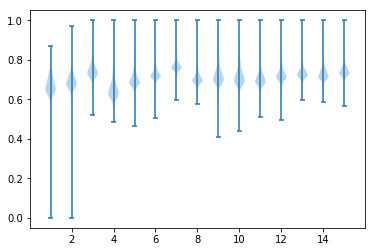

In [52]:
plt.violinplot(coop);

In [394]:
top_names_noise = list(average_prfs[1].sort_values()[:15].index)

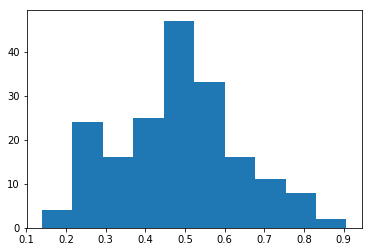

In [395]:
plt.hist(average_prfs[1]);

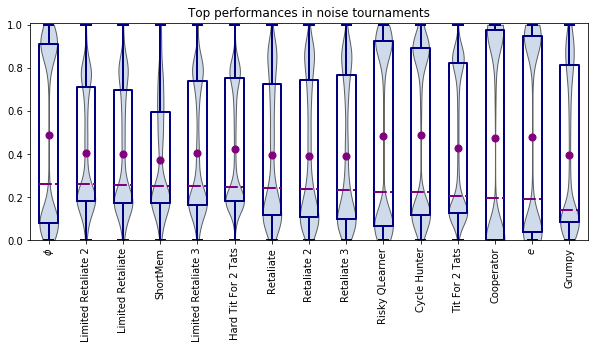

In [396]:
plot_perfomance_violin_plots(type_index=1,
                             tournament_type=types[1],
                             top_names=top_names_noise,
                             ylim_up=1.01)

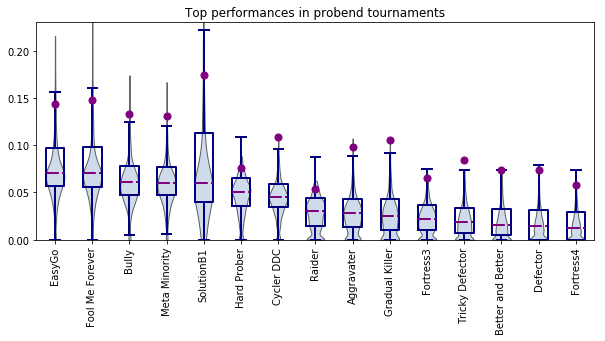

In [397]:
top_names_probend = list(average_prfs[2].sort_values()[:15].index)
plot_perfomance_violin_plots(type_index=2,
                             tournament_type=types[2],
                             top_names=top_names_probend,
                             ylim_up=.23,
                             remove_outliers=True,
                             percentage=0.12)

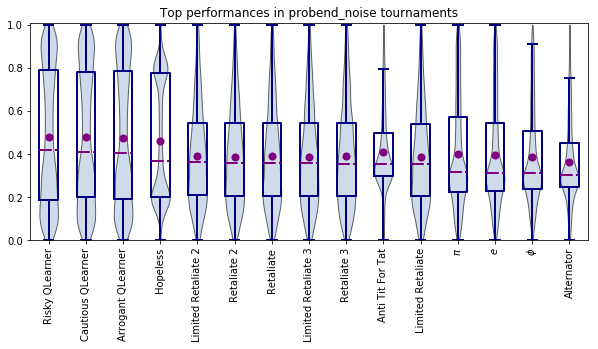

In [398]:
top_names_mixed = list(average_prfs[3].sort_values()[:15].index)
plot_perfomance_violin_plots(type_index=3,
                             tournament_type=types[3],
                             top_names=top_names_mixed,
                             ylim_up=1.01)

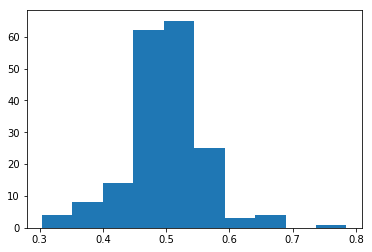

In [399]:
plt.hist(average_prfs[3].sort_values());

In [400]:
# fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

# for i, strategy_index in enumerate([1, -1]):
#     x = dfs[0][dfs[0]['Name'] == top_names[strategy_index]]['Cooperation_rating_x']
#     y = dfs[0][dfs[0]['Name'] == top_names[strategy_index]]['Normalized_Rank']
#     xy = np.vstack([x, y])
#     z = gaussian_kde(xy)(xy)

#     axes[i].scatter(x, y, c=z);

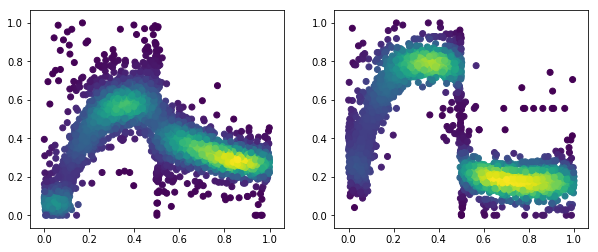

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

for i, strategy_index in enumerate([1, -1]):
    x = dfs[1][dfs[1]['Name'] == top_names_noise[strategy_index]]['noise']
    y = dfs[1][dfs[1]['Name'] == top_names_noise[strategy_index]]['Normalized_Rank']
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    axes[i].scatter(x, y, c=z);

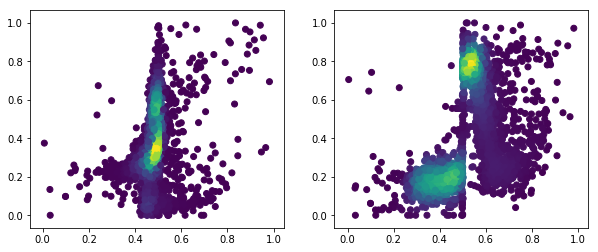

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

for i, strategy_index in enumerate([1, -1]):
    x = dfs[1][dfs[1]['Name'] == top_names_noise[strategy_index]]['Cooperation_rating_x']
    y = dfs[1][dfs[1]['Name'] == top_names_noise[strategy_index]]['Normalized_Rank']
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    axes[i].scatter(x, y, c=z);

In [12]:
dfs[0][dfs[0]['Name'] == 'BackStabber']['SSeeror'].describe()

count    5.671000e+03
mean     8.553363e-03
std      6.528935e-03
min      5.549462e-08
25%      6.970558e-03
50%      8.672386e-03
75%      9.447320e-03
max      8.006536e-02
Name: SSeeror, dtype: float64

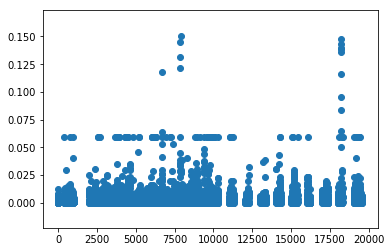

In [23]:
plt.scatter(dfs[0][dfs[0]['Name'] == 'DoubleCrosser']['seed'],
            dfs[0][dfs[0]['Name'] == 'DoubleCrosser']['SSeeror']);

In [34]:
winners = dfs[0][dfs[0]['Normalized_Rank'] == 0.0]

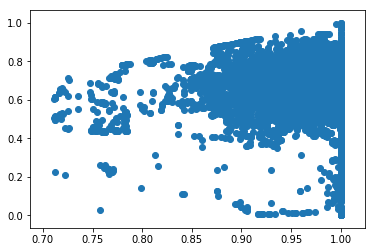

In [30]:
plt.scatter(winners['Cooperation_rating_max'], winners['Cooperation_rating']);

**r distribution**

In [58]:
x = winners['Cooperation_rating']
y = winners['Cooperation_rating_max']

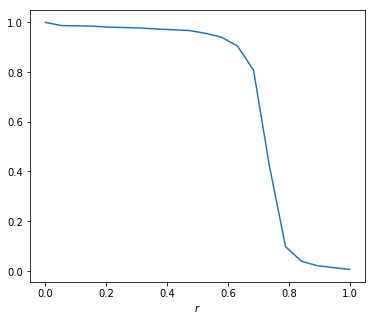

In [59]:
fig, axes = plt.subplots(figsize=(6, 5))

plt.plot(rs, [sum(x >= r * y) / len(x) for r in rs])
axes.set_xlabel(r"$r$");